<a href="https://colab.research.google.com/github/galenzo17/AI-personal-test/blob/main/Real_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vhbtkr3g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vhbtkr3g
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5f3cb0889d6484ae1a37d004d3af8fbef8559560aac8f423fcd282c6a4d5bd81
  Stored in directory: /tmp/pip-ephem-wheel-cache-ft3xtdw8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-10-19 01:25:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.4.39, 13.225.4.116, 13.225.4.105, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.4.3

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Modelo SAM cargado.
Por favor, sube la imagen a la que deseas aplicar el filtro:


Saving Captura desde 2024-10-18 22-26-04.png to Captura desde 2024-10-18 22-26-04.png
Imagen cargada correctamente.
Generando máscaras, esto puede tardar un momento...
Se generaron 50 máscaras.
Se encontraron 1 contornos.


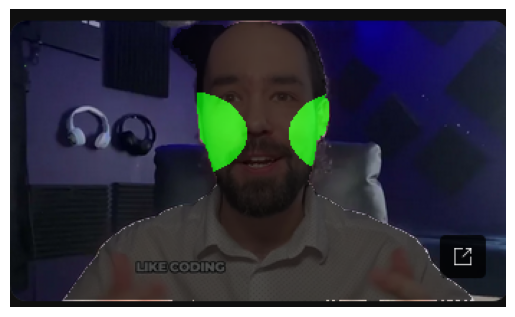

In [1]:
# Instalar las librerías necesarias
!pip install opencv-python
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision

# Descargar los pesos pre-entrenados del modelo SAM
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Importar las librerías
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from google.colab import files
import sys
%matplotlib inline

# Configurar el modelo SAM
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")
model_type = "vit_b"
sam_checkpoint = "sam_vit_b_01ec64.pth"

print("Cargando el modelo SAM...")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print("Modelo SAM cargado.")

# Ajustar los parámetros del generador de máscaras
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000,  # Filtra las máscaras pequeñas
)

try:
    # Subir la imagen a la que deseas aplicar el filtro
    print("Por favor, sube la imagen a la que deseas aplicar el filtro:")
    uploaded = files.upload()

    # Obtener el nombre del archivo subido
    image_filename = next(iter(uploaded))
    frame = cv2.imread(image_filename)

    # Verificar si la imagen se cargó correctamente
    if frame is None:
        print("Error al cargar la imagen. Asegúrate de subir una imagen válida.")
        sys.exit()

    print("Imagen cargada correctamente.")

    # Redimensionar la imagen si es demasiado grande
    max_size = 800
    if max(frame.shape) > max_size:
        scale = max_size / max(frame.shape)
        new_size = (int(frame.shape[1] * scale), int(frame.shape[0] * scale))
        frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)
        print(f"Imagen redimensionada a {new_size[0]}x{new_size[1]} píxeles.")

    # Convertir la imagen a RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Generar las máscaras
    print("Generando máscaras, esto puede tardar un momento...")
    masks = mask_generator.generate(frame_rgb)
    print(f"Se generaron {len(masks)} máscaras.")

    # Seleccionar la máscara más grande
    if len(masks) > 0:
        masks = sorted(masks, key=lambda x: x['area'], reverse=True)
        mask = masks[0]['segmentation']
    else:
        print("No se encontraron máscaras.")
        mask = np.zeros(frame.shape[:2], dtype=bool)

    # Crear un filtro simple (dibujar ojos de gato)
    # Aquí creamos un filtro básico usando círculos para simular ojos de gato
    filter_image = np.zeros_like(frame, dtype=np.uint8)

    # Encontrar el contorno de la máscara
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Se encontraron {len(contours)} contornos.")
    if contours:
        # Encontrar los puntos clave (simplificado)
        x, y, w, h = cv2.boundingRect(contours[0])

        # Coordenadas aproximadas para los ojos
        eye_width = int(w * 0.15)
        eye_height = int(h * 0.15)
        left_eye_center = (int(x + w * 0.3), int(y + h * 0.4))
        right_eye_center = (int(x + w * 0.7), int(y + h * 0.4))

        # Dibujar los ojos de gato
        cv2.ellipse(filter_image, left_eye_center, (eye_width, eye_height), 0, 0, 360, (0, 255, 0), -1)
        cv2.ellipse(filter_image, right_eye_center, (eye_width, eye_height), 0, 0, 360, (0, 255, 0), -1)

        # Aplicar el filtro a la imagen original
        alpha = 0.7  # Transparencia del filtro
        mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        frame = np.where(mask_expanded, cv2.addWeighted(frame, 1 - alpha, filter_image, alpha, 0), frame)
    else:
        print("No se encontraron contornos en la máscara.")

    # Mostrar el resultado
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Ocurrió un error: {e}")
